In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import translate_text
from sklearn.model_selection import KFold
import shap
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
from sklearn.model_selection import KFold
import torch.nn.functional as F
import io
from PIL import Image
from utils import get_cbcl_details
import random
import netron

In [2]:
seed = 8  # 你可以设成其他任何整数
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # 多卡也能同步
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 1:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.2)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

In [5]:
from utils import get_cbcl_details
items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]
items = np.array(items)

## Autoencoder

In [9]:
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# the autoencoder architecture
class AutoencoderModel(nn.Module):
    def __init__(
        self, input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
    ):
        super(AutoencoderModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),

        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        # forward
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



def is_nni_running():
    """If NNI is running, return True; otherwise, return False."""
    return "NNI_PLATFORM" in os.environ


def decorrelation_loss(latent_repr):
    """
    计算潜在表示的去相关正则化损失。
    latent_repr: (batch_size, latent_dim)
    """
    batch_size, latent_dim = latent_repr.shape
    # 计算协方差矩阵
    latent_repr = latent_repr - latent_repr.mean(dim=0, keepdim=True)  # 先中心化
    cov_matrix = (latent_repr.T @ latent_repr) / batch_size  # 计算协方差
    mask = torch.eye(latent_dim, device=latent_repr.device)  # 生成单位矩阵
    loss = torch.sum((cov_matrix * (1 - mask))**2)  # 只计算非对角元素
    return loss

class Autoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
    ):

        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = AutoencoderModel(
            input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.1, patience=5
        )
        self.explained_variance_ratio_total_value = None
    
    def get_model(self):
        return self.model
    
    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        # Modify the training loop to include decorrelation loss
        for epoch in range(2000):
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)
                
                # Calculate decorrelation loss
                latent_repr = self.model.encoder(batch_features)
                decorrelation_loss_value = decorrelation_loss(latent_repr)
                
                # Combine losses
                combined_loss = reconstruction_loss + decorrelation_loss_value
                
                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)
            train_losses.append(train_loss / len(self.train_loader.dataset))

            # Validation step
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)
                    
                    # Calculate decorrelation loss
                    latent_repr = self.model.encoder(batch_features)
                    decorrelation_loss_value = decorrelation_loss(latent_repr)
                    
                    # Combine losses
                    combined_loss = reconstruction_loss + decorrelation_loss_value
                    
                    val_loss += combined_loss.item() * batch_features.size(0)
            val_losses.append(val_loss / len(self.val_loader.dataset))
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            # Plot loss curves
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curves")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            # Forward pass to get reconstructed data
            if not isinstance(X, np.ndarray):
                X = np.array(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            reconstructed = self.model(X_tensor)

            # Get the output of the encoder, i.e., latent factors
            latent_factors = self.model.encoder(
                X_tensor
            ).cpu().numpy()

            # Calculate the variance of each latent factor
            latent_variances = np.var(latent_factors, axis=0)

            # Calculate the total variance of the original data
            total_variance = np.var(X, axis=0).sum()

            # Calculate the explained variance ratio for each latent factor
            explained_variance_ratios = latent_variances / total_variance

            # Print the explained variance ratio for each latent factor
            # for i, ratio in enumerate(explained_variance_ratios):
            #     print(f"Explained variance ratio of latent factor {i+1}: {ratio:.8f}")

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean(
                (X_tensor - reconstructed) ** 2,
                dim=1,
            ).cpu().numpy()

            # Calculate the variance contribution of the reconstructed data
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()

            # Calculate the total explained variance ratio
            explained_variance_ratio_total = reconstruction_variance / total_variance
            # print(
            #     f"Total explained variance ratio (by all factors): {explained_variance_ratio_total:.8f}"
            # )

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed
        )


## sparse AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# Sparse Autoencoder Model
class SparseAutoencoderModel(nn.Module):
    """
    Sparse autoencoder with an L-layer encoder and decoder. 
    Uses a KL-divergence-based sparsity penalty on the latent representation. 
    """

    def __init__(
        self,
        input_dim,
        latent_dim,
        layer1_neurons,
        layer2_neurons,
        layer3_neurons,
        sparsity_target=0.05,
        beta=1.0,
    ):
        super(SparseAutoencoderModel, self).__init__()
        self.sparsity_target = sparsity_target
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def kl_divergence_loss(self, avg_activation):
        """
        KL Divergence-based sparsity penalty:
            KL(p || q) = p * log(p/q) + (1 - p)*log((1 - p)/(1 - q))
        """
        # We clamp the activation to avoid log(0) or log(∞)
        avg_activation = torch.clamp(avg_activation, 1e-10, 1.0)
        p = self.sparsity_target
        return torch.sum(
            p * torch.log(p / avg_activation)
            + (1 - p) * torch.log((1 - p) / (1 - avg_activation))
        )

    def get_latent_activations(self, x):
        """Utility to get the latent representation for an input batch x."""
        return self.encoder(x)


# The main class that encapsulates training/evaluation
class SparseAutoencoder:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
        sparsity_target=0.05,
        beta=1.0,
    ):

        # Build Datasets/Dataloaders
        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        # Model initialization
        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = SparseAutoencoderModel(
            input_dim=input_dim,
            latent_dim=latent_dim,
            layer1_neurons=layer1_neurons,
            layer2_neurons=layer2_neurons,
            layer3_neurons=layer3_neurons,
            sparsity_target=sparsity_target,
            beta=beta,
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=5)

    def get_model(self):
        return self.model

    def train(self, show_plot=False):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        for epoch in range(2000):
            # Training
            self.model.train()
            train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(batch_features)
                reconstruction_loss = self.criterion(outputs, batch_features)

                # ===== Sparsity penalty =====
                # Compute average activation of latent representation
                latent_repr = self.model.get_latent_activations(batch_features)
                avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                # Alternatively, use raw latent_repr if you do not want absolute value:
                # avg_activation = torch.mean(latent_repr, dim=0)

                kl_loss = self.model.kl_divergence_loss(avg_activation)
                # Weighted penalty
                sparsity_penalty = self.model.beta * kl_loss

                combined_loss = reconstruction_loss + sparsity_penalty
                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)

            epoch_train_loss = train_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    outputs = self.model(batch_features)
                    reconstruction_loss = self.criterion(outputs, batch_features)

                    # KL in validation
                    latent_repr = self.model.get_latent_activations(batch_features)
                    avg_activation = torch.mean(torch.abs(latent_repr), dim=0)
                    kl_loss = self.model.kl_divergence_loss(avg_activation)

                    combined_loss = reconstruction_loss + self.model.beta * kl_loss
                    val_loss += combined_loss.item() * batch_features.size(0)

            epoch_val_loss = val_loss / len(self.val_loader.dataset)
            val_losses.append(epoch_val_loss)

            # Step scheduler
            self.scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Plot if requested
        if show_plot:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Sparse AE Training/Validation Loss")
            plt.show()

    def evaluate_on_data(self, X):
        self.model.eval()
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            reconstructed = self.model(X_tensor)

            # Get latent factors
            latent_factors = self.model.encoder(X_tensor).cpu().numpy()

            # Calculate reconstruction errors
            reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
            reconstruction_errors = reconstruction_errors.cpu().numpy()

            # Calculate explained variances
            latent_variances = np.var(latent_factors, axis=0)

            # Total variance of the original data
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # Total explained variance ratio
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance


        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed,
        )

    def export_to_onnx(self, X_train, onnx_path):
        # Use the first training sample as dummy input
        device = next(self.model.parameters()).device
        dummy_input = torch.tensor(X_train[:1], dtype=torch.float32).to(device)
        
        # Export the model to ONNX format
        torch.onnx.export(
            self.model,  # Trained model
            dummy_input,  # Use real data as example input
            onnx_path,  # Output file path
            input_names=["input"],  # Input name
            output_names=["reconstructed"],  # Output name
            dynamic_axes={
                "input": {0: "batch_size"},
                "reconstructed": {0: "batch_size"},
            },  # Dynamic batch size support
            opset_version=11,  # ONNX opset version
        )

        print(f"Model exported to {onnx_path}")

        # Start Netron to visualize the model
        netron.start(onnx_path)


## COAutoencoderModel

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ========= 基础设置 =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 数据集封装 =========
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

# ========= 聚类层 =========
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim):
        super(ClusteringLayer, self).__init__()
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, z):
        logits = torch.matmul(z, self.cluster_centers.t())
        return F.softmax(logits, dim=1)


# ========= 模型定义 =========
class COAEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, layer1, layer2, layer3, n_clusters):
        super(COAEModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1), nn.ReLU(),
            nn.Linear(layer1, layer2), nn.ReLU(),
            nn.Linear(layer2, layer3), nn.ReLU(),
            nn.Linear(layer3, latent_dim), nn.Sigmoid()  # ✅ 添加 sigmoid 控制输出范围
        )
        self.clustering_layer = ClusteringLayer(n_clusters, latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        enc0, enc2, enc4, enc6 = self.encoder[0], self.encoder[2], self.encoder[4], self.encoder[6]
        x = F.linear(z, enc6.weight.t()); x = F.relu(x)
        x = F.linear(x, enc4.weight.t()); x = F.relu(x)
        x = F.linear(x, enc2.weight.t()); x = F.relu(x)
        x = F.linear(x, enc0.weight.t())
        return x

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        p = self.clustering_layer(z)
        return x_hat, z, p

# ========= 去相关正则项 =========
def orthogonality_loss(z):
    z = z - z.mean(dim=0, keepdim=True)
    cov = (z.T @ z) / z.size(0)
    I = torch.eye(z.size(1)).to(z.device)
    return torch.sum((cov - I) ** 2)

# ========= 稀疏性 KL 散度函数 =========
def sparsity_kl_divergence(rho, rho_hat):
    rho_hat = torch.clamp(rho_hat, 1e-10, 1 - 1e-10)
    return torch.sum(
        rho * torch.log(rho / rho_hat) + 
        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    )

# ========= 聚类目标分布 Q =========
def compute_target_distribution(p):
    weight = (p ** 2) / torch.sum(p, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

# ========= COAE 训练器 =========
class COAETrainer:
    def __init__(self, X_train, X_val, latent_dim, layer1, layer2, layer3, n_clusters):
        self.train_loader = DataLoader(QuestionnaireDataset(X_train), batch_size=32, shuffle=True)
        self.val_loader = DataLoader(QuestionnaireDataset(X_val), batch_size=32)
        input_dim = X_train.shape[1]

        self.model = COAEModel(input_dim, latent_dim, layer1, layer2, layer3, n_clusters).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5)
        self.criterion = nn.MSELoss()

        self.lambda_orth = 1e-1
        self.mu_clust = 1.0
        self.lambda_sparsity = 1e-4
        self.sparsity_target = 0.8

    def train(self, show_plot=False):
        best_val_loss = float('inf')
        patience, epochs_no_improve = 50, 0
        train_losses, val_losses = [], []

        for epoch in range(200):
            self.model.train()
            total_train_loss = 0
            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()

                x_hat, z, p = self.model(batch_features)
                q = compute_target_distribution(p).detach()

                recon_loss = self.criterion(x_hat, batch_features)
                orth_loss = orthogonality_loss(z)
                clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                rho_hat = torch.mean(torch.sigmoid(z), dim=0)
                sparse_loss = sparsity_kl_divergence(self.sparsity_target, rho_hat)
                

                loss = recon_loss + \
                       self.lambda_orth * orth_loss + \
                       self.mu_clust * clust_loss + \
                       self.lambda_sparsity * sparse_loss

                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * batch_features.size(0)

            train_losses.append(total_train_loss / len(self.train_loader.dataset))

            # 验证
            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    x_hat, z, p = self.model(batch_features)
                    q = compute_target_distribution(p)

                    recon_loss = self.criterion(x_hat, batch_features)
                    orth_loss = orthogonality_loss(z)
                    clust_loss = F.kl_div(p.log(), q, reduction='batchmean')
                    rho_hat = torch.mean(torch.sigmoid(z), dim=0)
                    sparse_loss = sparsity_kl_divergence(self.sparsity_target, rho_hat)

                    val_loss = recon_loss + \
                               self.lambda_orth * orth_loss + \
                               self.mu_clust * clust_loss + \
                               self.lambda_sparsity * sparse_loss

                    total_val_loss += val_loss.item() * batch_features.size(0)

            val_loss_avg = total_val_loss / len(self.val_loader.dataset)
            val_losses.append(val_loss_avg)
            self.scheduler.step(val_loss_avg)
            print(f"  KL 稀疏损失: {sparse_loss.item():.4f}")
            print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss_avg:.4f}")

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        if show_plot:
            plt.plot(train_losses, label="Train")
            plt.plot(val_losses, label="Validation")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("COAE Loss Curves")
            plt.show()

    def get_latent_representation(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            return self.model.encode(X_tensor).cpu().numpy()


## VAE

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------- Dataset ---------------------------------
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # VAE 依旧是自监督任务，输入 = 目标
        return self.data[idx], self.data[idx]

# ------------------------- VAE Model -------------------------------
class VAEModel(nn.Module):
    def __init__(
        self, input_dim, latent_dim,
        layer1_neurons, layer2_neurons, layer3_neurons
    ):
        super(VAEModel, self).__init__()

        # ---------- Encoder ----------
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(0.01),
        )
        self.enc_mu     = nn.Linear(layer3_neurons, latent_dim)
        self.enc_logvar = nn.Linear(layer3_neurons, latent_dim)

        # ---------- Decoder ----------
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(0.01),
            nn.Linear(layer1_neurons, input_dim)
        )

    # ---------- Helpers ----------
    def encode(self, x):
        h = self.encoder_net(x)
        return self.enc_mu(h), self.enc_logvar(h)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# ------------------------- VAE Wrapper -----------------------------
class VariationalAutoencoder:
    def __init__(
        self, X_train, X_val, encoding_dim,
        layer1_neurons=0, layer2_neurons=0, layer3_neurons=0,
        beta_kl=1.0  # 可调节 KL 权重
    ):
        self.beta_kl = beta_kl

        train_ds = QuestionnaireDataset(X_train)
        val_ds   = QuestionnaireDataset(X_val)
        self.train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        self.val_loader   = DataLoader(val_ds,   batch_size=32)

        input_dim  = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = VAEModel(
            input_dim, latent_dim,
            layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)

        self.recon_loss_fn = nn.MSELoss(reduction="sum")  # sum → 方便 KL 归一化
        self.optim     = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optim, mode="min", factor=0.1, patience=5)

        self.explained_variance_ratio_total_value = None

    # ---------- Public ----------
    def get_model(self):
        return self.model

    def train(self, show_plot=False):
        best_val = float("inf")
        patience, wait = 20, 0
        train_hist, val_hist = [], []

        for epoch in range(2000):
            # ----- train step -----
            self.model.train()
            epoch_loss = 0
            for x, _ in self.train_loader:
                x = x.to(device)
                self.optim.zero_grad()

                recon, mu, logvar = self.model(x)
                # 重构误差（按样本平均）
                recon_loss = self.recon_loss_fn(recon, x) / x.size(0)
                # KL 散度
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + self.beta_kl * kl_loss

                loss.backward()
                self.optim.step()

                epoch_loss += loss.item() * x.size(0)

            train_hist.append(epoch_loss / len(self.train_loader.dataset))

            # ----- val step -----
            self.model.eval()
            val_loss_acc = 0
            with torch.no_grad():
                for x, _ in self.val_loader:
                    x = x.to(device)
                    recon, mu, logvar = self.model(x)
                    recon_loss = self.recon_loss_fn(recon, x) / x.size(0)
                    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + self.beta_kl * kl_loss
                    val_loss_acc += loss.item() * x.size(0)

            val_loss = val_loss_acc / len(self.val_loader.dataset)
            val_hist.append(val_loss)
            self.scheduler.step(val_loss)

            # Early-stopping
            if val_loss < best_val:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if show_plot:
            plt.plot(train_hist, label="Train")
            plt.plot(val_hist,   label="Val")
            plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("VAE Loss")
            plt.show()

    # 与原 evaluate_on_data 相同接口，内部逻辑切到 VAE
    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            X_np = np.asarray(X)
            X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)

            recon, mu, logvar = self.model(X_tensor)
            latent_factors = mu.cpu().numpy()  # 使用均值向量作为潜在表示

            # 下面的解释方差计算保持不变
            latent_variances = np.var(latent_factors, axis=0)
            total_variance  = np.var(X_np, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            rec_errors = torch.mean((X_tensor - recon) ** 2, dim=1).cpu().numpy()
            recon_variance = np.var(recon.cpu().numpy(), axis=0).sum()
            # evr_total = recon_variance / total_variance
            evr_total = 1 - np.var((X_tensor - recon).cpu().numpy(), axis=0).sum() / total_variance

            

        return (
            latent_factors,          # 潜在均值
            rec_errors,              # 样本重构误差
            explained_variance_ratios,
            evr_total,
            recon.cpu().numpy()      # 重构数据
        )

# ------------------------- 工具函数 -------------------------------
def is_nni_running():
    """If NNI is running, return True; otherwise, return False."""
    return "NNI_PLATFORM" in os.environ


## Beta VAE

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same


# Beta-VAE architecture
class BetaVAEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons):
        super(BetaVAEModel, self).__init__()

        # Encoder
        self.encoder_net = nn.Sequential(
            nn.Linear(input_dim, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.fc_mu = nn.Linear(layer3_neurons, latent_dim)
        self.fc_logvar = nn.Linear(layer3_neurons, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer3_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer3_neurons, layer2_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2_neurons, layer1_neurons),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1_neurons, input_dim),
        )

    def encode(self, x):
        h = self.encoder_net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

    def get_latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z


class BetaVAE:
    def __init__(
        self,
        X_train,
        X_val,
        encoding_dim,
        layer1_neurons=0,
        layer2_neurons=0,
        layer3_neurons=0,
    ):
        train_dataset = QuestionnaireDataset(X_train)
        val_dataset = QuestionnaireDataset(X_val)

        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=32)

        input_dim = X_train.shape[1]
        latent_dim = encoding_dim
        self.model = BetaVAEModel(
            input_dim, latent_dim, layer1_neurons, layer2_neurons, layer3_neurons
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=5)
        self.explained_variance_ratio_total_value = None

    def get_model(self):
        return self.model

    def train(self, show_plot=False, beta_max=0.5, kl_anneal_epochs=200, recon_loss_weight =100):
        best_val_loss = float("inf")
        patience = 20
        epochs_without_improvement = 0
        train_losses, val_losses = [], []

        for epoch in range(2000):
            self.model.train()
            train_loss = 0

            # KL annealing: 让 beta 从 0 慢慢涨到 beta_max
            beta = min(beta_max, beta_max * epoch / kl_anneal_epochs)

            for batch_features, _ in self.train_loader:
                batch_features = batch_features.to(device)
                self.optimizer.zero_grad()
                reconstructed, mu, logvar = self.model(batch_features)

                reconstruction_loss = self.criterion(reconstructed, batch_features)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_features.size(0)

                combined_loss = recon_loss_weight*reconstruction_loss + beta * kl_loss

                combined_loss.backward()
                self.optimizer.step()
                train_loss += combined_loss.item() * batch_features.size(0)
            train_losses.append(train_loss / len(self.train_loader.dataset))

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_features, _ in self.val_loader:
                    batch_features = batch_features.to(device)
                    reconstructed, mu, logvar = self.model(batch_features)

                    reconstruction_loss = self.criterion(reconstructed, batch_features)
                    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_features.size(0)
                    combined_loss = recon_loss_weight*reconstruction_loss + beta * kl_loss

                    val_loss += combined_loss.item() * batch_features.size(0)
            val_losses.append(val_loss / len(self.val_loader.dataset))
            self.scheduler.step(val_loss)

            print(f"Epoch {epoch+1}, Beta {beta:.4f}, Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

            # 每5个epoch监控潜变量分布
            if epoch % 5 == 0:
                batch_features, _ = next(iter(self.val_loader))
                batch_features = batch_features.to(device)
                self.model.eval()
                with torch.no_grad():
                    mu, logvar = self.model.encode(batch_features)
                    std = torch.exp(0.5 * logvar)
                    eps = torch.randn_like(std)
                    z = mu + eps * std
                    z = z.cpu().numpy()

                # 潜变量直方图
                plt.figure(figsize=(8, 4))
                plt.hist(z.flatten(), bins=50, density=True, alpha=0.6)
                plt.title(f"Latent variable histogram at epoch {epoch}")
                plt.xlabel("z value")
                plt.ylabel("Density")
                plt.show()

                # Q-Q图
                import scipy.stats as stats
                plt.figure(figsize=(6, 6))
                stats.probplot(z.flatten(), dist="norm", plot=plt)
                plt.title(f"Q-Q plot at epoch {epoch}")
                plt.show()

                # Shapiro-Wilk检验
                shapiro_test = stats.shapiro(z.flatten())
                print(f"Epoch {epoch}: Shapiro-Wilk p-value = {shapiro_test.pvalue:.5f}")
                print(f"Epoch {epoch}: Latent mean = {z.mean():.4f}, std = {z.std():.4f}")

        if show_plot:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curves")
            plt.show()


    def evaluate_on_data(self, X):
        self.model.eval()
        with torch.no_grad():
            if not isinstance(X, np.ndarray):
                X = np.array(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

            reconstructed, _, _ = self.model(X_tensor)

            latent_factors = self.model.get_latent(X_tensor).cpu().numpy()

            latent_variances = np.var(latent_factors, axis=0)
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed
        )


## FactorVAE

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim, dropout_rate=0.0):
        """
        编码器：将输入映射到潜在空间的均值和log-方差。
        参数:
        - input_dim: 输入数据的维度 (例如Flatten后长度，对图像可为 C*H*W)。
        - hidden_dims: 隐藏层神经元数量列表。
        - z_dim: 潜在空间维度。
        """
        super(Encoder, self).__init__()
        self.dropout_rate = dropout_rate
        # 构建全连接层序列
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU(True))
            layers.append(nn.Dropout(self.dropout_rate))
            prev_dim = h_dim
        # 最终层输出2*z_dim，因为要同时输出均值和log方差
        layers.append(nn.Linear(prev_dim, 2 * z_dim))
        self.net = nn.Sequential(*layers)
        self.z_dim = z_dim

    def forward(self, x):
        """
        前向传播：输出潜在分布的均值mu和对数方差logvar。
        """
        stats = self.net(x)                # 得到长度为2*z_dim的向量
        mu = stats[:, :self.z_dim]         # 前半部分作为均值
        logvar = stats[:, self.z_dim:]     # 后半部分作为log-方差
        # FactorVAE新增: 输出均值和log方差用于随机采样潜在向量
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dims, output_dim, dropout_rate=0.0):

        """
        解码器：将潜在向量重建为输出。
        参数:
        - z_dim: 潜在空间维度。
        - hidden_dims: 隐藏层神经元数量列表（解码层）。
        - output_dim: 重建输出的维度（例如Flatten后长度）。
        """
        super(Decoder, self).__init__()
        self.dropout_rate = dropout_rate
        layers = []
        prev_dim = z_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU(True))
            layers.append(nn.Dropout(self.dropout_rate))
            prev_dim = h_dim
        # 最终层输出为原始数据维度大小
        layers.append(nn.Linear(prev_dim, output_dim))
        # 如果输出是图像像素，可视需要添加激活如Sigmoid；这里假设后续损失会处理
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        """
        前向传播：将潜在向量z解码为重建输出。
        """
        x_recon = self.net(z)
        return x_recon

class Discriminator(nn.Module):
    def __init__(self, z_dim, hidden_dims=[200, 200]):
        """
        判别器：判断输入的潜在向量是否来自真实编码分布q(z)或独立因素分布prod(q(z_j))。
        参数:
        - z_dim: 潜在空间维度。
        - hidden_dims: 隐藏层神经元数量列表。
        """
        super(Discriminator, self).__init__()
        layers = []
        prev_dim = z_dim
        # 构建一系列全连接层（使用LeakyReLU作为激活）
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = h_dim
        # 最终输出2分类（两个logits，对应标签0或1）
        layers.append(nn.Linear(prev_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        """
        前向传播：输出对数几率(logits)值（大小为2，表示属于各类别的未归一化分数）。
        """
        logits = self.net(z)
        return logits
class FactorVAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        """
        FactorVAE模型：包含Encoder和Decoder。
        """
        super(FactorVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def encode(self, x):
        return self.encoder(x)


    def reparameterize(self, mu, logvar):
        """
        FactorVAE新增: 重参数化采样。根据给定的均值mu和对数方差logvar采样潜在向量z。
        公式: z = mu + sigma * epsilon, 其中epsilon ~ N(0, I), sigma = exp(0.5 * logvar)
        """
        # 计算标准差
        std = torch.exp(0.5 * logvar)
        # 从标准正态分布采样epsilon，与std形状相同 (保持device一致)
        eps = torch.randn_like(std)    # 【FactorVAE新增】确保epsilon在相同设备上采样
        # 返回采样的潜在变量
        return mu + std * eps

    def forward(self, x):
        """
        前向传播：输出重建结果以及潜在分布参数和采样结果。
        返回: (x_recon, mu, logvar, z)
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z
class Trainer:
    def __init__(self, model: FactorVAE, discriminator: Discriminator,
                 lr_vae=1e-3, lr_d=1e-3, beta_max=0.1, warmup_epochs=10, device=None):
        """
        Trainer初始化:
        - model: FactorVAE模型 (包含encoder和decoder)
        - discriminator: 判别器模型
        - lr_vae: VAE部分的学习率
        - lr_d: 判别器的学习率
        - beta_max: β的最大值 (最终惩罚系数)
        - warmup_epochs: β从0涨到beta_max所持续的epoch数
        - device: 训练使用的设备 (cpu或cuda)
        """
        self.model = model
        self.discriminator = discriminator
        self.beta_max = beta_max
        self.warmup_epochs = warmup_epochs
        # 优化器
        self.optim_vae = torch.optim.Adam(self.model.parameters(), lr=lr_vae)
        self.optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        # 设置设备
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        self.model.to(device)
        self.discriminator.to(device)
        # 用一个 dict 来存所有曲线
        self.history = {
            'recon': [],    # 重建 loss
            'kl': [],       # KL loss
            'tc': [],       # Total Correlation loss
            'd': [],        # 判别器 loss
            'vae_total': [],# VAE 综合 loss
            'beta': [],     # 每个 epoch 的 β 值
        }
    def _permute_latent(self, z):
        """
        FactorVAE新增: 打乱潜在向量z各维度。用于生成独立分布样本\bar{q}(z)。
        输入: z: Tensor shape [batch, z_dim]
        输出: 打乱每个维度后的z_perm (每一列来自原z的一组随机重排)
        """
        # 对每个潜在维度独立随机打乱
        B, D = z.size()
        z_perm = []
        for j in range(D):
            idx = torch.randperm(B, device=self.device)  # 在当前设备上生成随机索引
            z_j = z[:, j]          # 取出第j维 (shape [B])
            z_perm_j = z_j[idx]    # 打乱该维的所有batch样本顺序
            z_perm.append(z_perm_j)
        z_perm = torch.stack(z_perm, dim=1)
        return z_perm

    def train(self, data_loader, num_epochs):
        """
        训练模型。每个epoch逐步增加β值，并在每个训练step交替优化VAE和判别器。
        """
        self.model.train()
        self.discriminator.train()
        for epoch in range(1, num_epochs+1):
            # 线性暖启动: 计算当前epoch使用的β (从0增加到beta_max)
            if epoch <= self.warmup_epochs:
                beta = self.beta_max * (epoch / float(self.warmup_epochs))
            else:
                beta = self.beta_max
                        # 计算 warm-up 后的 beta
            # 累加本 epoch 的各项 loss
            epoch_recon = epoch_kl = epoch_tc = epoch_d = epoch_vae = 0.0
            n_batches = 0
            for batch in data_loader:
                n_batches += 1
                if isinstance(batch, (list, tuple)):
                    x = batch[0].to(self.device)
                else:
                    x = batch.to(self.device)
            # 1. 计算当前batch的大小                
                # ----------------------
                # 判别器更新步骤 (D-step)
                # ----------------------
                # 1. 从当前模型获取潜在向量 z（编码器前向+采样），并生成打乱的z_perm
                # 注意：用 detach() 确保在D步骤中不更新VAE的编码器/解码器
                with torch.no_grad():
                    mu, logvar = self.model.encoder(x)
                    z = self.model.reparameterize(mu, logvar)
                z_det = z.detach()                      # detach之后的z用于判别器训练
                z_perm = self._permute_latent(z_det)    # 打乱得到z_perm
                # 2. 计算判别器预测
                logits_z = self.discriminator(z_det)         # 判别器预测真实z的logits
                logits_z_perm = self.discriminator(z_perm)   # 判别器预测独立z_perm的logits
                # 3. 判别器损失: 真实z标签为0，打乱z标签为1
                # 使用交叉熵损失来区分，两者损失取平均
                labels_z = torch.zeros(logits_z.size(0), dtype=torch.long, device=self.device)      # 全0标签
                labels_z_perm = torch.ones(logits_z_perm.size(0), dtype=torch.long, device=self.device)  # 全1标签
                loss_d_real = F.cross_entropy(logits_z, labels_z)         # 真实z的判别损失
                loss_d_fake = F.cross_entropy(logits_z_perm, labels_z_perm)  # 打乱z的判别损失
                loss_d = 0.5 * (loss_d_real + loss_d_fake)                # 综合判别器损失
                # … 计算 loss_d …
                epoch_d += loss_d.item()
                # 4. 反向传播和优化判别器
                self.optim_d.zero_grad()
                loss_d.backward()
                self.optim_d.step()

                # ----------------------
                # VAE更新步骤 (VAE-step)
                # ----------------------
                # 5. 前向传播获取模型输出和重新采样的z（注意：需要重新计算以建立梯度图）
                x_recon, mu, logvar, z = self.model(x)
                # 6. 计算重建损失 (例如MSE误差)
                # 将每个样本的重建误差求和再取平均
                recon_loss = ((x_recon - x) ** 2).view(x.size(0), -1).sum(dim=1).mean()
                # 7. 计算KL散度损失 (使用解析形式)
                # KL(q(z|x) || p(z)) = 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar )
                kl_loss = 0.5 * (logvar.exp() + mu**2 - 1. - logvar).sum(dim=1).mean()
                # 8. 计算VAE的对抗损失（Total Correlation近似）
                # 判别器在此时的参数保持不变，仅用于提供梯度给VAE
                # 将判别器参数暂时禁止梯度，以确保只优化VAE
                for p in self.discriminator.parameters():
                    p.requires_grad = False
                logits_z = self.discriminator(z)   # 判别器对当前z的输出
                # VAE希望“欺骗”判别器，把真实z也判为类别1（即独立分布样本）
                labels_trick = torch.ones(logits_z.size(0), dtype=torch.long, device=self.device)
                tc_loss = F.cross_entropy(logits_z, labels_trick)
                # 恢复判别器参数的requires_grad，准备下次判别器更新
                for p in self.discriminator.parameters():
                    p.requires_grad = True
                # 9. 综合VAE损失: 重建误差 + KL散度 + β * 对抗损失
                loss_vae = recon_loss + kl_loss + beta * tc_loss   # FactorVAE新增: β权衡TC损失
                # … 计算 recon_loss, kl_loss, tc_loss, loss_vae …
                epoch_recon += recon_loss.item()
                epoch_kl    += kl_loss.item()
                epoch_tc    += tc_loss.item()
                epoch_vae   += loss_vae.item()
                # 10. 反向传播和优化VAE (encoder+decoder)
                self.optim_vae.zero_grad()
                loss_vae.backward()
                self.optim_vae.step()
            print(f"Epoch {epoch}, Batch {n_batches}, Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, TC Loss: {tc_loss.item():.4f}, D Loss: {loss_d.item():.4f}")
            # 取平均并存入 history
            self.history['recon'].append(epoch_recon   / n_batches)
            self.history['kl'].append(epoch_kl          / n_batches)
            self.history['tc'].append(epoch_tc          / n_batches)
            self.history['d'].append(epoch_d            / n_batches)
            self.history['vae_total'].append(epoch_vae  / n_batches)
            self.history['beta'].append(beta)
        self.plot_history()
        
    def plot_history(self):
        """使用 Matplotlib 绘制训练过程中的 loss 曲线和 β 升温曲线。"""
        # Loss 曲线
        plt.figure(figsize=(8,5))
        plt.plot(self.history['recon'],    label='Reconstruction')
        plt.plot(self.history['kl'],       label='KL')
        plt.plot(self.history['tc'],       label='TC')
        plt.plot(self.history['vae_total'],label='VAE Total')
        plt.plot(self.history['d'],        label='Discriminator')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Loss Curves')
        plt.show()

        # β 升温曲线
        plt.figure(figsize=(6,4))
        plt.plot(self.history['beta'], label='β Value')
        plt.xlabel('Epoch')
        plt.ylabel('β')
        plt.title('Warm-up β Schedule')
        plt.show()
    def evaluate_on_data(self, X):
        """
        在数据 X（numpy array 或 list）上评估：
        - 重建结果 reconstructed
        - 潜在因子 latent_factors
        - 每个潜在因子的解释方差比 explained_variance_ratios
        - 总体解释方差比 explained_variance_ratio_total
        - 每个样本的重建误差 reconstruction_errors

        返回：
          (latent_factors, reconstruction_errors,
           explained_variance_ratios,
           explained_variance_ratio_total,
           reconstructed)
        """
        device = self.device
        self.model.eval()

        # 转为 numpy / Tensor
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

        with torch.no_grad():
            # forward 直接返回 (recon, mu, logvar, z)
            reconstructed, mu, logvar, z = self.model(X_tensor)

            # 将 z 转为 numpy
            latent_factors = z.cpu().numpy()

            # 每个因子的方差与总方差
            latent_variances = np.var(latent_factors, axis=0)
            total_variance = np.var(X, axis=0).sum()
            explained_variance_ratios = latent_variances / total_variance

            # 样本级别重建均方误差
            reconstruction_errors = (
                (X_tensor - reconstructed).pow(2)
                .mean(dim=1)
                .cpu()
                .numpy()
            )

            # 重建输出整体方差贡献
            reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
            # explained_variance_ratio_total = reconstruction_variance / total_variance
            explained_variance_ratio_total = 1 - np.var((X_tensor - reconstructed).cpu().numpy(), axis=0).sum() / total_variance

        return (
            latent_factors,
            reconstruction_errors,
            explained_variance_ratios,
            explained_variance_ratio_total,
            reconstructed.cpu().numpy()
        )

# train the model

Early stopping at epoch 88


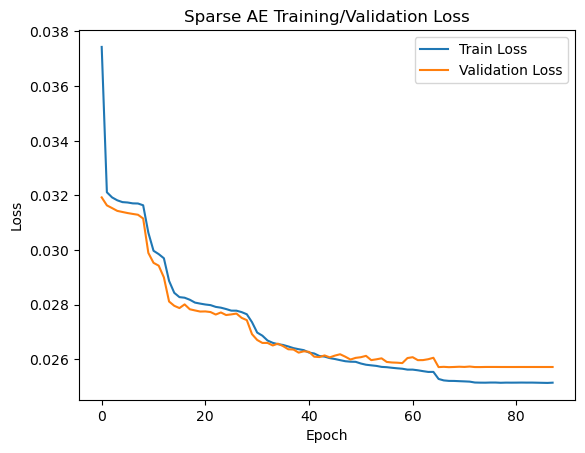

Explained Variance Ratio (total): 0.3547444727738417


In [17]:
sparseAE = SparseAutoencoder(
    X_train=X_train,
    X_val=X_val,
    encoding_dim=5,             # 必须提供，潜在维度
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,
    sparsity_target=0.05,
    beta=1.0,
)

sparseAE.train(show_plot=True)

# 评估
mu_z, rec_errs, evr_each, evr_total, X_recon = sparseAE.evaluate_on_data(X_test)
print("Explained Variance Ratio (total):", evr_total)


Early stopping at epoch 66


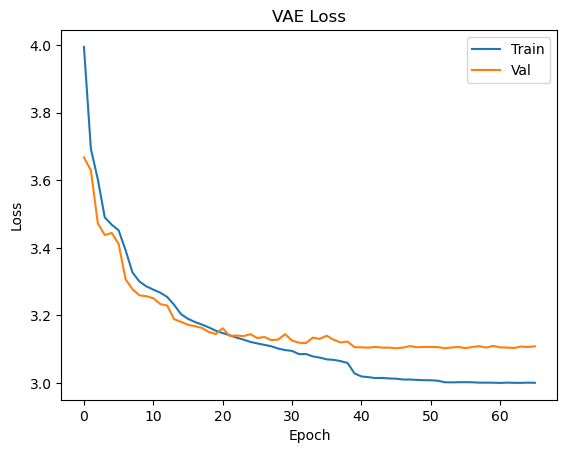

0.3465507635839741

In [ ]:
vae = VariationalAutoencoder(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,
    beta_kl=0.1          # β-VAE 可自由调节
)
vae.train(show_plot=True)

mu_z, rec_errs, evr_each, evr_total, X_recon = vae.evaluate_on_data(X_test)
evr_total


In [36]:
mu_z, rec_errs, evr_each, evr_total, X_recon = vae.evaluate_on_data(X_train)
evr_total

0.38382876273338684

In [ ]:
bvae = BetaVAE(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,         # β-VAE 可自由调节
)
bvae.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = bvae.evaluate_on_data(X_train)

Epoch 1: Train Loss=0.1380, Val Loss=0.1416
Epoch 2: Train Loss=0.1439, Val Loss=0.1358
Epoch 3: Train Loss=0.1416, Val Loss=0.1410
Epoch 4: Train Loss=0.1393, Val Loss=0.1325
Epoch 5: Train Loss=0.1279, Val Loss=0.1187
Epoch 6: Train Loss=0.1137, Val Loss=0.1054
Epoch 7: Train Loss=0.1036, Val Loss=0.0975
Epoch 8: Train Loss=0.0966, Val Loss=0.0954
Epoch 9: Train Loss=0.0915, Val Loss=0.0898
Epoch 10: Train Loss=0.0885, Val Loss=0.0881
Epoch 11: Train Loss=0.0849, Val Loss=0.0849
Epoch 12: Train Loss=0.0828, Val Loss=0.0819
Epoch 13: Train Loss=0.0801, Val Loss=0.0804
Epoch 14: Train Loss=0.0774, Val Loss=0.0778
Epoch 15: Train Loss=0.0754, Val Loss=0.0765
Epoch 16: Train Loss=0.0739, Val Loss=0.0753
Epoch 17: Train Loss=0.0729, Val Loss=0.0734
Epoch 18: Train Loss=0.0707, Val Loss=0.0724
Epoch 19: Train Loss=0.0698, Val Loss=0.0712
Epoch 20: Train Loss=0.0683, Val Loss=0.0703
Epoch 21: Train Loss=0.0671, Val Loss=0.0695
Epoch 22: Train Loss=0.0664, Val Loss=0.0684
Epoch 23: Train Los

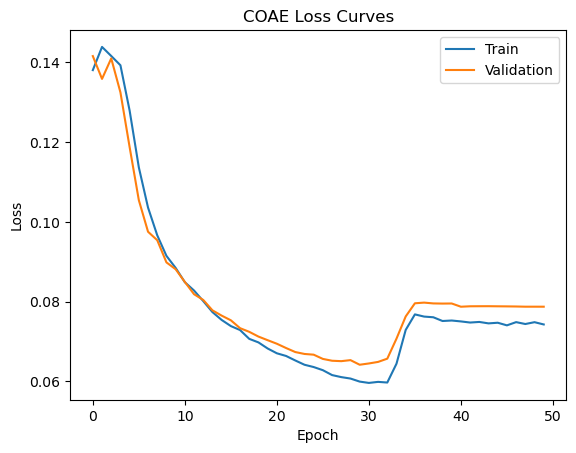

Total Explained Variance Ratio (COAE): 0.21512548477861848


In [34]:
coae = COAETrainer(X_train, X_val, 
    latent_dim=5, 
    layer1=128, 
    layer2=64, 
    layer3=32, 
    n_clusters=5)
coae.train(show_plot=True)

z, rec_errs, evr_each, evr_total, X_recon = coae.evaluate_on_data(X_train)

print("Total Explained Variance Ratio (COAE):", evr_total)


Early stopping at epoch 59


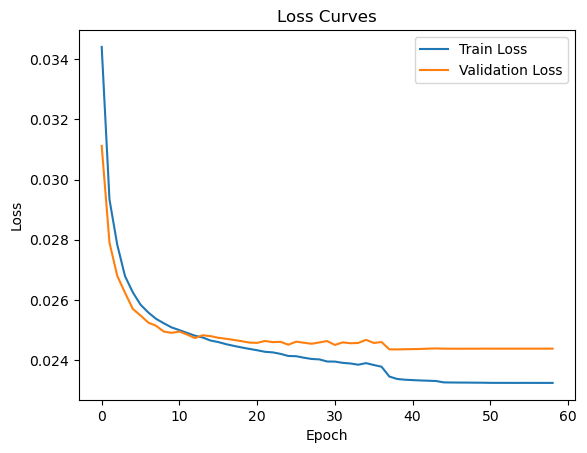

0.42273332016774323

In [29]:
autoencoder = Autoencoder(
    X_train, X_val,
    encoding_dim=5,
    layer1_neurons=128,
    layer2_neurons=64,
    layer3_neurons=32,         # β-VAE 可自由调节
)
autoencoder.train(show_plot=True)

latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed = autoencoder.evaluate_on_data(X_train)
# 这里的 X_train, X_val, X_test 是预先定义好的数据集
explained_variance_ratio_total

Early stopping at epoch 143


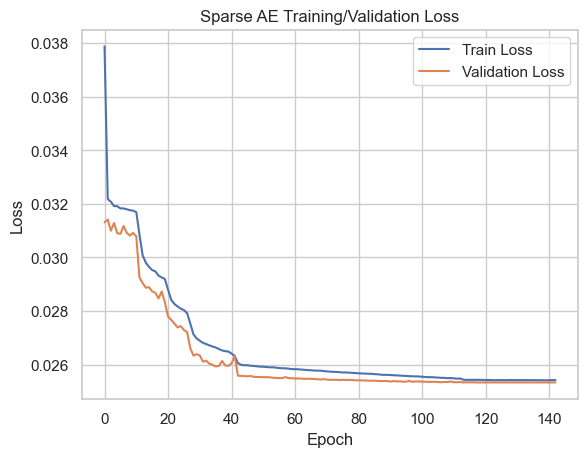

In [ ]:
# 示例参数
encoding_dim = 5
layer1_neurons = 127
layer2_neurons = 117
layer3_neurons = 106
# layer1_neurons = 128
# layer2_neurons = 64
# layer3_neurons = 32
# layer4_neurons = 90
# n_clusters = 4  # 可根据需要调整聚类数

# 初始化 COAETrainer（推荐使用该封装）
autoencoder = SparseAutoencoder(
    X_train=X_train,
    X_val=X_val,
    encoding_dim=encoding_dim,
    layer1_neurons=layer1_neurons,
    layer2_neurons=layer2_neurons,
    layer3_neurons=layer3_neurons,
    # layer4_neurons=layer4_neurons,
    # n_clusters=n_clusters
)

# 开始训练
autoencoder.train(show_plot=True)
# autoencoder.export_to_onnx(X_train, onnx_path = "../output/sparse_autoencoder.onnx")

## NMF-AE

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF


# 1. 数据准备
X_train_np = np.array(X_train)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型超参数
input_dim = X_train_np.shape[1]
z_dim = 5               # 潜在因子维度
layer1_neurons = 5
layer2_neurons = 16
layer3_neurons = 32

# 3. NMF 分解
nmf_model = NMF(n_components=z_dim, init='random', max_iter=5000)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"NMF 字典 H_nmf 形状: {H_nmf.shape}")
# 3. 还原重建结果
reconstructed = np.dot(W_nmf, H_nmf)

# # 4. 计算潜变量 (W) 的每个因子的方差
# latent_variances = np.var(W_nmf, axis=0)  # W 是 (n_samples, n_components)

# # 5. 计算总方差
# total_variance = np.var(X_train, axis=0).sum()

# # 6. 每个潜变量解释方差的比例
# explained_variance_ratios = latent_variances / total_variance

# # 7. 样本级别重建误差（MSE）
# reconstruction_errors = np.mean((X_train - reconstructed) ** 2, axis=1)

# # 8. 重建后的总方差贡献
# reconstruction_variance = np.var(reconstructed, axis=0).sum()
# explained_variance_ratio_total = reconstruction_variance / total_variance
# 假设：X_train 是 (n_samples, n_features)，
# reconstructed 是 NMF 重建结果 (n_samples, n_features)

# 1. 计算残差
residuals = X_train - reconstructed

# 2. 原始数据每个特征的方差 Var(X_j)
var_original = np.var(X_train, axis=0)

# 3. 残差每个特征的方差 Var(X_j - Ŷ_j)
var_residual  = np.var(residuals, axis=0)

# 4. 每个特征的 VAF = 1 - Var(residual) / Var(original)
explained_variance_ratios = 1 - (var_residual / var_original)

# 5. 计算总体的 VAF
total_var_original = var_original.sum()
total_var_residual = var_residual.sum()
explained_variance_ratio_total = 1 - (total_var_residual / total_var_original)

# 6. 样本级别重建误差（MSE）
reconstruction_errors = np.mean(residuals**2, axis=1)

# 9. 打印
print("每个潜变量解释的方差比例：", explained_variance_ratios)
print("总重建解释方差比例：", explained_variance_ratio_total)
print("平均样本重建MSE：", reconstruction_errors.mean())

# 4. 构建深度 AE (Encoder + Decoder)
class DeepVAE(nn.Module):
    def __init__(self, input_dim, layer1, layer2, layer3, latent_dim, init_W=None):
        super(DeepVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(layer2, layer3),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2, 2 * latent_dim),  # 输出 mu 与 logvar
        )
        self.latent_dim = latent_dim
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, layer2),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(layer3, layer2),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer2, layer1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(layer1, input_dim),
        )
        # 用 NMF 字典初始化 Decoder 最后一层
        if init_W is not None:
            # init_W: (latent_dim, input_dim) -> 需要转置匹配 PyTorch Linear weight (out_features, in_features)
            final_lin = self.decoder[-1]
            final_lin.weight.data.copy_(torch.tensor(init_W, dtype=torch.float32))
            final_lin.bias.data.zero_()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        stats = self.encoder(x)
        mu = stats[:, :self.latent_dim]
        logvar = stats[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# 5. 实例化深度 VAE 并用 NMF 字典初始化 Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = DeepVAE(
    input_dim=input_dim,
    layer1=layer1_neurons,
    layer2=layer2_neurons,
    layer3=layer3_neurons,
    latent_dim=z_dim,
    init_W=H_nmf.T
).to(device)

# 6. AE 预训练（只用重建 MSE）
optimizer_ae = torch.optim.Adam(vae_model.parameters(), lr=5e-4)
num_ae_epochs = 200
vae_model.train()
for epoch in range(1, num_ae_epochs+1):
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar, z = vae_model(x)
        loss = F.mse_loss(recon, x, reduction='mean')
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item()
    if epoch % 3 == 0:
        print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# 7. 添加 evaluate_on_data 函数

def evaluate_on_data(model, device, X):
    model.eval()
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    with torch.no_grad():
        reconstructed, mu, logvar, z = model(X_tensor)
        latent_factors = z.cpu().numpy()

        # 计算残差
        X_hat = reconstructed.cpu().numpy()
        residuals = X - X_hat

        # 对每个特征维度计算 VAF
        var_original = np.var(X, axis=0)
        var_residual = np.var(residuals, axis=0)
        # VAF = 1 - Var(residual) / Var(original)
        explained_variance_ratios = 1 - (var_residual / var_original)

        # 总体 VAF
        total_var_original = var_original.sum()
        total_var_residual = var_residual.sum()
        explained_variance_ratio_total = 1 - (total_var_residual / total_var_original)

        reconstruction_errors = (
            (X_tensor - reconstructed).pow(2)
            .mean(dim=1)
            .cpu()
            .numpy()
        )

    return (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
        X_hat
    )


NMF 字典 H_nmf 形状: (5, 114)
每个潜变量解释的方差比例： [0.25730375 0.5608881  0.47976494 0.16902041 0.01226743 0.2193808
 0.77386736 0.39838645 0.60561987 0.23408989 0.24275379 0.18481093
 0.20202455 0.038942   0.26792823 0.31785716 0.04011502 0.40146709
 0.27083753 0.32099677 0.53249683 0.35135752 0.12644329 0.27034913
 0.33329049 0.35975509 0.53781145 0.20866193 0.13484047 0.18703061
 0.30027789 0.30921072 0.18642439 0.30387154 0.16722157 0.18715406
 0.21562195 0.12756499 0.03065738 0.52069781 0.17809222 0.37661586
 0.96514178 0.42322512 0.18950967 0.16155631 0.21826525 0.10923777
 0.47817489 0.12211074 0.21467777 0.14318335 0.11518628 0.09500263
 0.25730396 0.45334594 0.33918405 0.02951565 0.13308938 0.4717522
 0.1033127  0.04499721 0.23008676 0.23594065 0.0121425  0.02360307
 0.28858073 0.20581225 0.13652412 0.15995955 0.1643834  0.18074103
 0.04109856 0.35470992 0.21002437 0.02716063 0.46442794 0.02176118
 0.29137853 0.27377303 0.12104754 0.03863346 0.76038881 0.05159083
 0.22028769 0.16427818 0

## NMF-AE one layer

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已经定义为 NumPy 数组，X_test 同理。
# ----------------------------------------------------------------
# 1. 数据准备
X_train_np = np.array(X_train)
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 定义模型超参数
input_dim = X_train_np.shape[1]
z_dim = 5               # 潜在因子维度
# 对于 Method1, 使用 无隐藏层 AE 以直接利用 NMF 初始化
ae_hidden_dims = []     # 取消所有隐藏层

# 3. NMF 分解
nmf_model = NMF(n_components=z_dim, init='random', max_iter=500)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"NMF 字典 H_nmf 形状: {H_nmf.shape}")
# 3. 还原重建结果
reconstructed = np.dot(W_nmf, H_nmf)

# 4. 计算潜变量 (W) 的每个因子的方差
latent_variances = np.var(W_nmf, axis=0)  # W 是 (n_samples, n_components)

# 5. 计算总方差
total_variance = np.var(X_train, axis=0).sum()

# 6. 每个潜变量解释方差的比例
explained_variance_ratios = latent_variances / total_variance

# 7. 样本级别重建误差（MSE）
reconstruction_errors = np.mean((X_train - reconstructed) ** 2, axis=1)

# 8. 重建后的总方差贡献
reconstruction_variance = np.var(reconstructed, axis=0).sum()
explained_variance_ratio_total = reconstruction_variance / total_variance

# 9. 打印
print("每个潜变量解释的方差比例：", explained_variance_ratios)
print("总重建解释方差比例：", explained_variance_ratio_total)
print("平均样本重建MSE：", reconstruction_errors.mean())


# 4. 构建无隐藏层的 AE (Encoder + Decoder)
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(SimpleEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, 2*z_dim)
        self.z_dim = z_dim
    def forward(self, x):
        stats = self.fc(x)
        mu      = stats[:, :self.z_dim]
        logvar  = stats[:, self.z_dim:]
        return mu, logvar

class SimpleDecoder(nn.Module):
    def __init__(self, z_dim, output_dim, init_W=None):
        super(SimpleDecoder, self).__init__()
        self.fc = nn.Linear(z_dim, output_dim)
        if init_W is not None:
            # init_W shape must be (z_dim, output_dim)
            self.fc.weight.data.copy_(init_W)
            self.fc.bias.data.zero_()
    def forward(self, z):
        return self.fc(z)

class SimpleVAE(nn.Module):
    def __init__(self, enc, dec):
        super(SimpleVAE, self).__init__()
        self.encoder = enc
        self.decoder = dec
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# 5. 实例化简单 AE 并用 NMF 字典初始化 Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_ae  = SimpleEncoder(input_dim=input_dim, z_dim=z_dim)
decoder_ae  = SimpleDecoder(z_dim=z_dim, output_dim=input_dim,
                             init_W=torch.tensor(H_nmf.T, dtype=torch.float32))
ae_model = SimpleVAE(encoder_ae, decoder_ae).to(device)

# 6. AE 预训练（只用重建 MSE）
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=5e-4)
num_ae_epochs = 200
ae_model.train()
for epoch in range(1, num_ae_epochs+1):
    running_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar, z = ae_model(x)
        loss = F.mse_loss(recon, x, reduction='mean')
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"[AE Pretrain] Epoch {epoch}/{num_ae_epochs}, Recon MSE: {running_loss/len(train_loader):.4f}")

# 7. 将预训练的 Decoder 权重 迁移回原始深度模型
# factor_vae.decoder.net[-1] 应对应解码器最后一层的 Linear
# 示例：
# factor_vae.decoder.net[-1].weight.data.copy_(ae_model.decoder.fc.weight.t())
# factor_vae.decoder.net[-1].bias.data.copy_(ae_model.decoder.fc.bias)

# 8. 添加 evaluate_on_data 方法

def evaluate_on_data(model, device, X):
    """
    在数据 X（numpy array 或 list）上评估：
    - 重建结果 reconstructed
    - 潜在因子 latent_factors
    - 每个潜在因子的解释方差比 explained_variance_ratios
    - 总体解释方差比 explained_variance_ratio_total
    - 每个样本的重建误差 reconstruction_errors

    返回：
      (latent_factors, reconstruction_errors,
       explained_variance_ratios,
       explained_variance_ratio_total,
       reconstructed)
    """
    model.eval()
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    with torch.no_grad():
        reconstructed, mu, logvar, z = model(X_tensor)
        latent_factors = z.cpu().numpy()

        latent_variances = np.var(latent_factors, axis=0)
        total_variance = np.var(X, axis=0).sum()
        explained_variance_ratios = latent_variances / total_variance

        reconstruction_errors = (
            (X_tensor - reconstructed).pow(2)
            .mean(dim=1)
            .cpu()
            .numpy()
        )

        reconstruction_variance = np.var(reconstructed.cpu().numpy(), axis=0).sum()
        explained_variance_ratio_total = reconstruction_variance / total_variance

    return (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
        reconstructed.cpu().numpy()
    )

# ======================================================================
# 后续可用 evaluate_on_data(ae_model, device, X_test) 查看预训练 AE 表现。
# 同理，对深度 FactorVAE 可使用相同函数进行评估。
# ======================================================================


NMF 字典 H_nmf 形状: (5, 114)
每个潜变量解释的方差比例： [0.03263488 0.01623925 0.01362298 0.0041333  0.00718668]
总重建解释方差比例： 0.32428239633427464
平均样本重建MSE： 0.026824917411773765
[AE Pretrain] Epoch 10/200, Recon MSE: 0.0317
[AE Pretrain] Epoch 20/200, Recon MSE: 0.0277
[AE Pretrain] Epoch 30/200, Recon MSE: 0.0269
[AE Pretrain] Epoch 40/200, Recon MSE: 0.0267
[AE Pretrain] Epoch 50/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 60/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 70/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 80/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 90/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 100/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 110/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 120/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 130/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 140/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 150/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 160/200, Recon MSE: 0.0265
[AE Pretrain] Epoch 170/200, Recon MSE: 0.0264
[AE Pretrain] Epoch 180/200, Recon MSE: 0.0264
[AE

In [39]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        ) = evaluate_on_data(ae_model, 'cuda', X_train)  # 评估重建效果
explained_variance_ratio_total # 0.348534457451562
# reconstruction_errors.mean()

0.3487539514005602

In [ ]:
(
latent_factors,
reconstruction_errors,
explained_variance_ratios,
explained_variance_ratio_total,
reconstructed
        ) = evaluate_on_data(ae_model, 'cuda', X_test)  # 评估重建效果
explained_variance_ratio_total # 0.348534457451562
# reconstruction_errors.mean()

0.3380845429378257

## NMF-Factor-AE

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import NMF

# 假设 X_train 已定义为 NumPy 数组，这里开始 Method5：在 FactorVAE 中直接融合 NMF 结构
# ======================================================================
# 1. 数据准备
X_train_np = np.array(X_train)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_np, dtype=torch.float32)),
                          batch_size=32, shuffle=True)

# 2. NMF 分解
z_dim = 5  # 潜在因子数量
input_dim = X_train_np.shape[1]
nmf_model = NMF(n_components=z_dim, init='random', random_state=42, max_iter=500)
W_nmf = nmf_model.fit_transform(X_train_np)    # (n_samples, z_dim)
H_nmf = nmf_model.components_                  # (z_dim, input_dim)
print(f"Loaded NMF dictionary H_nmf with shape {H_nmf.shape}")

# 3. 构建融合 NMF 结构的 FactorVAE
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim, dropout_rate=0.0):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.01), nn.Dropout(dropout_rate)]
            prev = h
        layers.append(nn.Linear(prev, 2*z_dim))
        self.net = nn.Sequential(*layers)
        self.z_dim = z_dim

    def forward(self, x):
        stats = self.net(x)
        mu, logvar = stats[:, :self.z_dim], stats[:, self.z_dim:]
        return mu, logvar

class NMFDecoder(nn.Module):
    """只含一层线性层，权重矩阵即 NMF 字典。"""
    def __init__(self, init_W):
        super().__init__()
        # init_W: numpy array of shape (z_dim, input_dim)
        self.W = nn.Parameter(torch.tensor(init_W, dtype=torch.float32), requires_grad=True)

    def forward(self, z):
        # z: (batch,z_dim), W: (z_dim,input_dim)
        return torch.matmul(z, self.W)

class FactorVAE_NMF(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

class Discriminator(nn.Module):
    def __init__(self, z_dim, hidden_dims=[200,200]):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(0.2)]
            prev = h
        layers.append(nn.Linear(prev, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

# 4. 训练器（和之前相同的 Trainer 支持 TC loss）
class Trainer:
    def __init__(self, model, discriminator,
                 lr_vae=1e-3, lr_d=1e-3, beta_max=0.1,
                 warmup_epochs=10, device=None):
        self.model = model
        self.discriminator = discriminator
        self.optim_vae = torch.optim.Adam(self.model.parameters(), lr=lr_vae)
        self.optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.beta_max = beta_max
        self.warmup_epochs = warmup_epochs
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.discriminator.to(self.device)

    def _permute_latent(self, z):
        B,D = z.size()
        z_perm = []
        for j in range(D):
            idx = torch.randperm(B, device=z.device)
            z_perm.append(z[:,j][idx])
        return torch.stack(z_perm, dim=1)

    def train(self, data_loader, num_epochs):
        for epoch in range(1, num_epochs+1):
            beta = self.beta_max * min(epoch / self.warmup_epochs, 1.0)
            for batch in data_loader:
                x = batch[0].to(self.device)
                # D-step
                with torch.no_grad():
                    mu, logvar = self.model.encoder(x)
                    z = self.model.reparameterize(mu, logvar)
                z_det = z.detach()
                z_perm = self._permute_latent(z_det)
                logits_real = self.discriminator(z_det)
                logits_fake = self.discriminator(z_perm)
                loss_d = 0.5*(F.cross_entropy(logits_real, torch.zeros(z_det.size(0),dtype=torch.long,device=self.device))
                             + F.cross_entropy(logits_fake, torch.ones(z_perm.size(0),dtype=torch.long,device=self.device)))
                self.optim_d.zero_grad(); loss_d.backward(); self.optim_d.step()
                # VAE-step
                x_recon, mu, logvar, z = self.model(x)
                recon_loss = ((x_recon - x)**2).view(x.size(0),-1).sum(dim=1).mean()
                kl_loss = 0.5*(logvar.exp() + mu**2 - 1 - logvar).sum(dim=1).mean()
                for p in self.discriminator.parameters(): p.requires_grad=False
                logits_z = self.discriminator(z)
                tc_loss = F.cross_entropy(logits_z, torch.ones(z.size(0),dtype=torch.long,device=self.device))
                for p in self.discriminator.parameters(): p.requires_grad=True
                loss_vae = recon_loss + kl_loss + beta * tc_loss
                self.optim_vae.zero_grad(); loss_vae.backward(); self.optim_vae.step()
        print("Training complete.")

    def evaluate_on_data(self, X):
        self.model.eval()
        X_np = np.array(X)
        X_t = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            recon, mu, logvar, z = self.model(X_t)
            latent = z.cpu().numpy()
            latent_var = np.var(latent, axis=0)
            total_var = np.var(X_np, axis=0).sum()
            evr = latent_var / total_var
            recon_errs = ((X_t - recon)**2).mean(dim=1).cpu().numpy()
            recon_var = np.var(recon.cpu().numpy(), axis=0).sum()
            evr_total = recon_var / total_var
        return latent, recon_errs, evr, evr_total, recon.cpu().numpy()

# 5. 实例化并训练
hidden_dims = [112,106,96]
encoder = Encoder(input_dim, hidden_dims, z_dim)
decoder = NMFDecoder(H_nmf)
model = FactorVAE_NMF(encoder, decoder)
discriminator = Discriminator(z_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(model, discriminator, beta_max=0.1, warmup_epochs=10, device=device)
trainer.train(train_loader, num_epochs=100)

# 6. 评估效果
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_train_np)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio:.4f}")


Loaded NMF dictionary H_nmf with shape (5, 114)
Training complete.
FactorVAE+NMF 总体方差解释率: 0.2161


In [42]:
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_train_np)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio}")

FactorVAE+NMF 总体方差解释率: 0.21836170959920712


In [43]:
latent, errs, ratios, total_ratio, recon = trainer.evaluate_on_data(X_test)
print(f"FactorVAE+NMF 总体方差解释率: {total_ratio}")

FactorVAE+NMF 总体方差解释率: 0.20943931084487807


In [143]:
ve_per_feature = 1 - np.var(X_train - reconstructed.cpu().numpy(), axis=0) / np.var(X_train, axis=0)
print("每道题的解释方差率:", ve_per_feature)
# 输出小于 0.1 的题目
low_variance_items = np.where(ve_per_feature < 0.1)[0]

print("解释方差率小于 0.1 的题目索引:", low_variance_items)

print("解释方差率小于 0.1 的题目:", items[low_variance_items])

每道题的解释方差率: [0.44129521 0.74635498 0.62178664 0.32509369 0.04522597 0.46398031
 0.80425968 0.51736982 0.74112287 0.48488176 0.33903182 0.3586391
 0.33162522 0.12677298 0.40322187 0.56181902 0.14152614 0.53487782
 0.41126752 0.48605481 0.66493017 0.54299201 0.20833082 0.39683628
 0.39107087 0.4808158  0.6231356  0.47865885 0.23383235 0.29254954
 0.68864821 0.44269748 0.35237935 0.49906331 0.21925217 0.37265918
 0.34459417 0.24827698 0.12133257 0.57140763 0.46656581 0.47450914
 0.84015729 0.56227642 0.35128409 0.23666716 0.36135491 0.14211919
 0.62426421 0.19800991 0.35589617 0.62281258 0.23402123 0.86776387
 0.25862455 0.55528842 0.48254062 0.09159151 0.15636727 0.56670169
 0.17643835 0.08236272 0.37496791 0.38841846 0.08871555 0.07919207
 0.4630625  0.35800398 0.40890433 0.30851986 0.31658676 0.3543786
 0.1087248  0.48883584 0.33108973 0.12897671 0.6667305  0.09791466
 0.54691235 0.61663619 0.1989133  0.10221106 0.81267439 0.32789568
 0.40262221 0.36046825 0.32626275 0.27589547 0.375774

# Interpretability for all models

In [40]:
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
# original_features = X if isinstance(X, np.ndarray) else X.values
original_features = (
    X_train if isinstance(X_train, np.ndarray) else X_train.values
)

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]
scaler = StandardScaler()
latent_factors_scaled = scaler.fit_transform(latent_factors)
loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
# loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]
loadings_df.index = items


In [ ]:
# test 
# 确保 latent_factors 是 ndarray
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)

# 同样确保原始特征矩阵是 ndarray
original_features = (
    X_train if isinstance(X_train, np.ndarray) else X_train.values
)

# 标准化 latent_factors 和 original_features
scaler_latent = StandardScaler()
latent_scaled = scaler_latent.fit_transform(latent_factors)

scaler_orig = StandardScaler()
orig_scaled = scaler_orig.fit_transform(original_features)

# 获取维度信息
n_original_features = orig_scaled.shape[1]
n_latent_factors = latent_scaled.shape[1]

# 存储相关系数
correlations = []

# 计算 Pearson 相关系数
for i in range(n_original_features):
    y = orig_scaled[:, i]  # 单个原始变量（已标准化）
    corr = [np.corrcoef(latent_scaled[:, j], y)[0, 1] for j in range(n_latent_factors)]
    correlations.append(corr)

# 转换为 DataFrame，方便查看
loadings_df = pd.DataFrame(
    correlations,
    columns=[f"Latent_{j+1}" for j in range(n_latent_factors)],
    index=items  # 原始特征名
)


In [45]:
loadings_df = loadings_df.reindex(
    loadings_df['Latent_1'].abs().sort_values(ascending=False).index
)
loadings_df

,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5
Argues a lot Discute mucho,0.728024,-0.048488,-0.025794,0.094021,-0.082107
Disobedient at home Desobedece en casa,0.703054,-0.015961,0.024440,-0.080356,-0.127129
"Breaks rules at home, school or elsewhere No respeta/rompe las reglas en casa, en la escuela, o en otro\n lugar",0.693852,-0.018898,0.117669,-0.119856,-0.162340
Temper tantrums or hot temper Le dan rabietas o tiene mal genio,0.687489,-0.026126,-0.070889,0.000165,0.034687
"Stubborn, sullen, or irritable Obstinado(a), malhumorado(a), irritable",0.672165,-0.013206,-0.049346,0.036868,0.126300
...,...,...,...,...,...
Problems with eyes (not if corrected by glasses) Problemas con los ojos (no incluya si se corrigió con\n gafas/lentes/espejuelos),0.108964,0.007105,0.040612,0.043494,0.101743
Plays with own sex parts in public Se toca/juega con sus partes sexuales en público,0.108750,0.036167,0.029594,0.018905,0.014590
Bowel movements outside toilet Hace sus necesidades en la ropa o en lugares inadecuados,0.100667,0.009209,0.055560,-0.015326,0.041757
Thumb-sucking Se chupa el dedo,0.059744,0.006620,0.025450,0.002969,0.004958


In [48]:
#save loadings_df
loadings_df.to_csv("../output/latent_loadings.csv", index=True, encoding='utf-8-sig')

In [46]:
import numpy as np

def average_absolute_correlation(matrix):
    """
    计算输入矩阵各列之间的平均绝对相关系数。
    
    参数:
        matrix: shape (N, d)，这里假定每行是一个样本，每列是一个factor/loading
    
    返回:
        avg_abs_corr: 所有列两两相关系数取绝对值后的平均值
    """
    # 1) 计算 d x d 的相关系数矩阵 (列 vs 列)
    corr_matrix = np.corrcoef(matrix, rowvar=False)  # rowvar=False表示按列计算相关
    
    # 2) 取上三角（不含对角线）的索引
    d = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(d, k=1)  # (行索引数组, 列索引数组)
    
    # 3) 取出相关系数，并计算其绝对值
    off_diag_corr_values = corr_matrix[upper_tri_indices]  # 非对角线元素
    abs_off_diag = np.abs(off_diag_corr_values)
    
    # 4) 求平均
    avg_abs_corr = np.mean(abs_off_diag)
    
    return avg_abs_corr


# ==== 示例用法 ====
if __name__ == "__main__":
    # 模拟一个 latent factor 矩阵, shape = (N, d)
    # 比如 N=1000, d=5    
    # 计算 latent factors 的平均绝对相关
    avg_corr_latent = average_absolute_correlation(latent_factors)
    print("Average absolute correlation of latent factors:", avg_corr_latent)
    
    # 如果有 loading_factors 矩阵，同理：
    # loading_factors = ...
    # avg_corr_loading = average_absolute_correlation(loading_factors)
    # print("Average absolute correlation of loading factors:", avg_corr_loading)


Average absolute correlation of latent factors: 0.05701990706128788


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_22448\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


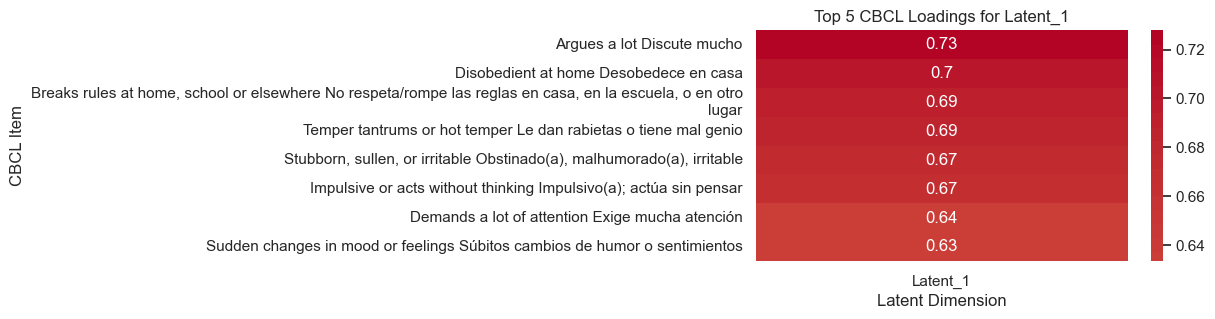

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_22448\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


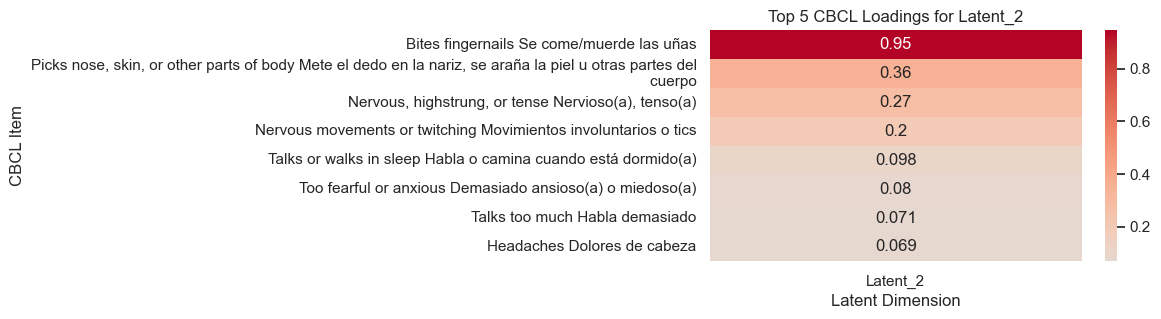

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_22448\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


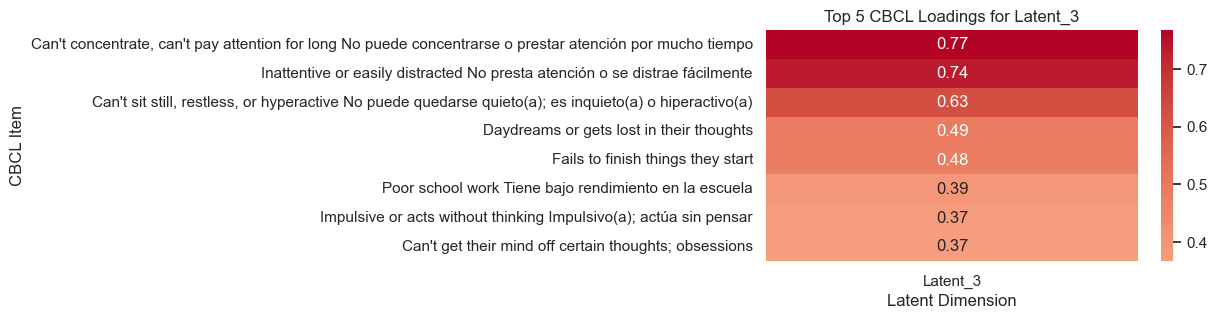

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_22448\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


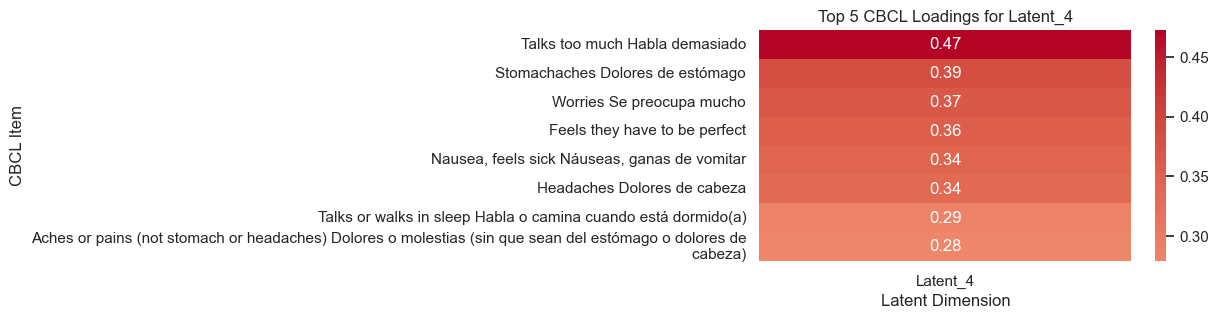

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_22448\1298907062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


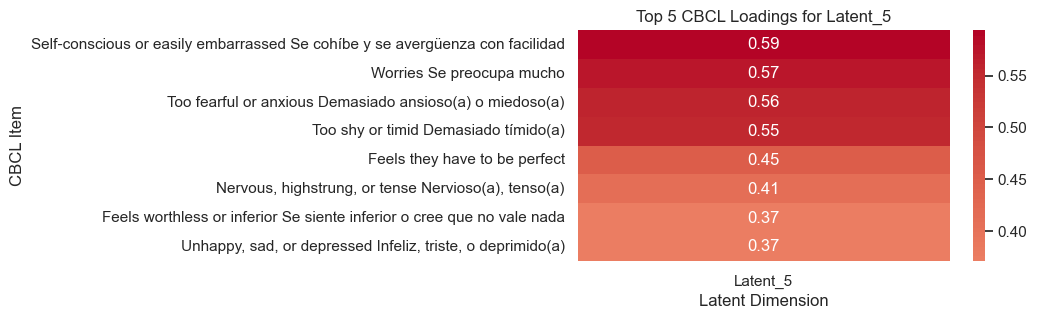

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set(style='whitegrid')

# 遍历每一列（latent）
for col in loadings_df.columns:
    # 获取当前列绝对值最大的前5个特征（CBCL item）
    top5 = loadings_df[col].abs().sort_values(ascending=False).head(8).index
    top5_data = loadings_df.loc[top5, [col]]

    # 绘图
    plt.figure(figsize=(6, 3))  # 每张图小一些方便展示
    sns.heatmap(top5_data, annot=True, cmap='coolwarm', center=0, cbar=True)
    plt.title(f"Top 5 CBCL Loadings for {col}")
    plt.xlabel("Latent Dimension")
    plt.ylabel("CBCL Item")
    plt.tight_layout()
    plt.show()

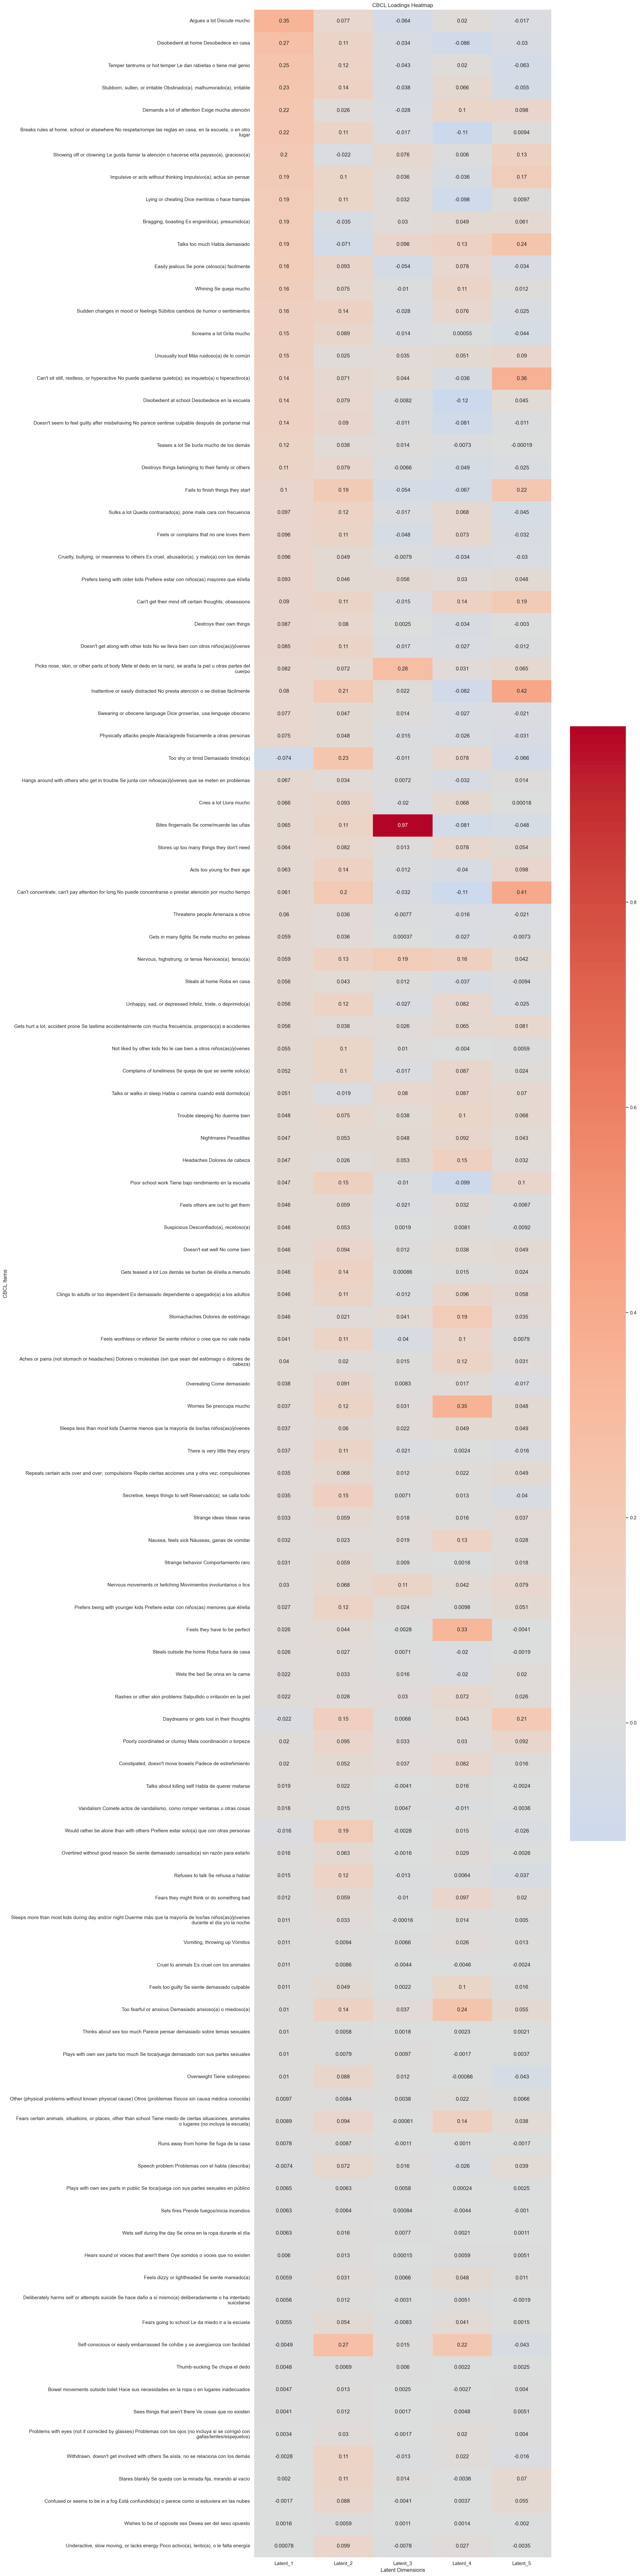

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 80))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("CBCL Loadings Heatmap")
plt.xlabel("Latent Dimensions")
plt.ylabel("CBCL Items")
plt.tight_layout()
plt.show()


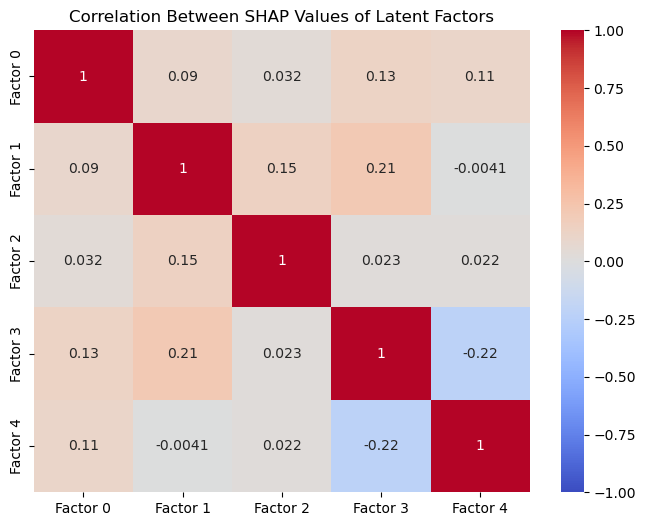

In [19]:
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 封装 autoencoder 的 encoder 部分为一个 nn.Module 对象
class EncoderWrapper(nn.Module):
    def __init__(self, model):
        super(EncoderWrapper, self).__init__()
        self.model = model  # 传入整个 autoencoder 模型

    def forward(self, x):

        output = self.model.encoder(x)  # 只返回编码器输出
        return output.clone()  # 返回编码器输出的副本
# 获取完整模型并封装 encoder
full_model = autoencoder.model
encoder_model = EncoderWrapper(full_model)
encoder_model.to(device)
encoder_model.eval()
for m in full_model.encoder.modules():
    # if you used nn.ReLU(inplace=True), switch it off
    if isinstance(m, torch.nn.ReLU):
        m.inplace = False
# 随机选取 100 个背景样本，保证背景数据与模型输入特征一致
background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

# 构建 SHAP DeepExplainer，注意将背景数据转换为 tensor 并移至相同设备
explainer = shap.DeepExplainer(encoder_model, 
                               torch.tensor(background, dtype=torch.float32).to(device))

# 计算前 20 个测试样本的 SHAP 值
shap_values = explainer.shap_values(torch.tensor(X_test[:20], dtype=torch.float32).to(device))

# 将 latent_dim 向量分别 flatten 为 (n_samples × n_features) 的一列，用于计算 pairwise correlation
latent_dim = shap_values.shape[2]
shap_flat = []

for i in range(latent_dim):
    # 每一列是 flatten 后的第 i 个因子的 SHAP 值
    flattened = shap_values[:, :, i].reshape(-1)
    shap_flat.append(flattened)

# 构成 DataFrame：每列代表一个因子
shap_df = pd.DataFrame(np.array(shap_flat).T, columns=[f"Factor {i}" for i in range(latent_dim)])

# 计算 Pearson 相关性矩阵
corr_matrix = shap_df.corr(method='pearson')

# 可视化
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between SHAP Values of Latent Factors")
plt.show()


In [20]:
%matplotlib inline
# model = autoencoder.get_model().encoder
# model =model.Encoder()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(model, torch.tensor(background, dtype=torch.float32).to(device), )

# 计算 SHAP 值
shap_values = explainer.shap_values(torch.tensor(X_test[:20], dtype=torch.float32).to(device))

NameError: name 'model' is not defined

In [ ]:
import shap
import matplotlib.pyplot as plt
import io
from PIL import Image

# We'll store each SHAP summary_plot as an in-memory PNG, then display them
images = []

for i in range(5):
    # 1) Create the SHAP summary plot on a brand-new figure
    shap.summary_plot(shap_values[:,:,i], X_test[:20], feature_names=items, show=False)
    plt.xlim(shap_values.min(), shap_values.max())
    
    # 2) Grab that just-created figure object
    tmp_fig = plt.gcf()
    
    # 3) Save it to a buffer in PNG format
    buf = io.BytesIO()
    tmp_fig.savefig(buf, format='png', bbox_inches='tight', dpi=300)
    buf.seek(0)
    
    # 4) Convert buffer -> PIL image and store
    images.append(Image.open(buf))
    
    # 5) Close that figure to avoid overlapping the next iteration
    plt.close(tmp_fig)

# Now create a single "master" figure of 1 row × 4 columns
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,5), dpi=1000)

for idx, ax in enumerate(axes):
    # 6) Display each PIL image in its own subplot
    ax.imshow(images[idx])
    ax.set_axis_off()
    ax.set_title(f"Factor {idx}")

plt.tight_layout()
plt.show()
